In [0]:
!nvidia-smi

Sun Jan 26 07:22:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import pynvml
pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)
device_name = pynvml.nvmlDeviceGetName(handle)
if (device_name != b'Tesla T4') and (device_name != b'Tesla P100-PCIE-16GB'):
  raise Exception("""
    Unfortunately this instance does not have a T4 or P100 GPU.
    
    Please make sure you've configured Colab to request a GPU instance type.
    
    Sometimes Colab allocates a Tesla K80 instead of a T4 or P100. Resetting the instance.
If you get a K80 GPU, try Runtime -> Reset all runtimes...
  """)
else:
  print(f'Yes, you got the right kind of GPU to work and it is a ({device_name}) GPU.')

Yes, you got the right kind of GPU to work and it is a (b'Tesla T4') GPU.


In [0]:
!wget -nc https://github.com/rapidsai/notebooks-extended/raw/master/utils/rapids-colab.sh
!bash rapids-colab.sh

import sys, os

sys.path.append('/usr/local/lib/python3.6/site-packages/')
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'

--2020-01-26 07:22:27--  https://github.com/rapidsai/notebooks-extended/raw/master/utils/rapids-colab.sh
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/rapidsai/notebooks-contrib/raw/master/utils/rapids-colab.sh [following]
--2020-01-26 07:22:27--  https://github.com/rapidsai/notebooks-contrib/raw/master/utils/rapids-colab.sh
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rapidsai/notebooks-contrib/master/utils/rapids-colab.sh [following]
--2020-01-26 07:22:27--  https://raw.githubusercontent.com/rapidsai/notebooks-contrib/master/utils/rapids-colab.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubuserconten

# **Uniform Manifold Approximation and Projection (UMAP)** 
UMAP is a dimensionality reduction algorithm which performs non-linear dimension reduction. It can also be used for visualization of the dataset. The UMAP model implemented in cuML allows the user to set the following parameter values:
1.	n_neighbors: number of neighboring samples used for manifold approximation. Larger values result in more global views of the manifold, while smaller values result in more local data being preserved (default = 15)
2.	n_components: the dimension of the space to embed into (default = 2)
3.	n_epochs: number of training epochs to be used in optimizing the low dimensional embedding (default = None)
4.	learning_rate: initial learning rate for the embedding optimization (default = 1.0)
5.	init: the low dimensional embedding to use: a. 'spectral': use a spectral embedding of the fuzzy 1-skeleton b. 'random': assign initial embedding positions at random (default = 'spectral')
6.	min_dist: the minimum distance that should be present between embedded points (default = 0.1)
7.	spread: determines how clustered the embedded points will be (default = 1.0)
8.	set_op_mix_ratio: is the ratio of pure fuzzy union to intersection. If the value is 1.0 then it will be a pure fuzzy union and for the value of 0.0 it will be a pure fuzzy interpolation (default = 1.0)
9.	local_connectivity: number of nearest neighbors that should be assumed to be connected at a local level. It should be not more than the local intrinsic dimension of the manifold (default = 1)
10.	repulsion_strength: weighting applied to negative samples in low dimensional embedding optimization. Values > 1 implements a higher negative value to the samples (default = 1.0)
11.	negative_sample_rate: the rate at which the negative samples should be selected per positive sample during the optimization process (default = 5)
12.	transform_queue_size: embedding new points using a trained model_ will control how aggressively to search for nearest neighbors (default = 4.0)
13.	verbose: bool (default False)

The cuml implemetation of the UMAP model has the following functions that one can run:
1.	fit: it fits the dataset into an embedded space
2.	fit_transform: it fits the dataset into an embedded space and returns the transformed output
3.	transform: it transforms the dataset into an existing embedded space and returns the low dimensional output

The model accepts only numpy arrays or cudf dataframes as the input. In order to convert your dataset to cudf format please read the cudf documentation on https://rapidsai.github.io/projects/cudf/en/latest/. For additional information on the UMAP model please refer to the documentation on https://rapidsai.github.io/projects/cuml/en/0.6.0/api.html#cuml.UMAP

In [0]:
import os
import time

import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.manifold.t_sne import trustworthiness

import cudf
from cuml.manifold.umap import UMAP

## **Running cuML's UMAP model on blobs dataset** 

In [0]:
# create a blobs dataset with 500 samples and 10 features each
data, labels = datasets.make_blobs(n_samples=500, 
                                   n_features=10, 
                                   centers=5)

In [0]:
data

array([[-2.8203916 , -8.43750851, -9.44213397, ..., -0.03165303,
         1.59645202, -7.08641878],
       [-3.26473405,  7.07186752, -0.20974529, ..., -4.39482572,
        -6.04295568,  3.78476683],
       [-3.38317467, -8.45884419, -8.84122805, ...,  0.80544156,
         3.44170493, -8.70447048],
       ...,
       [-3.90600423,  6.03899939, -1.13111225, ..., -6.86805507,
        -5.67892586,  5.67620332],
       [-1.83913258, -7.54701579,  8.30393129, ...,  7.27440698,
         3.06882864, -1.51429551],
       [-5.09268082, -9.78286779, -9.28793852, ..., -0.3870805 ,
         3.57216025, -7.84515385]])

In [0]:
type(data)

numpy.ndarray

In [0]:
data.shape

(500, 10)

In [0]:
data[0].shape

(10,)

In [0]:
labels

array([1, 2, 1, 0, 3, 4, 2, 0, 1, 0, 3, 1, 0, 2, 2, 4, 3, 0, 2, 1, 4, 2,
       1, 0, 3, 1, 4, 3, 4, 2, 3, 3, 0, 2, 4, 3, 3, 4, 3, 0, 0, 4, 0, 4,
       1, 3, 2, 1, 2, 3, 1, 0, 1, 4, 0, 0, 2, 0, 1, 0, 4, 3, 0, 1, 3, 1,
       3, 3, 4, 1, 2, 3, 1, 2, 0, 0, 4, 1, 0, 4, 1, 1, 2, 2, 1, 1, 2, 2,
       3, 2, 0, 4, 0, 0, 4, 1, 2, 3, 3, 4, 4, 0, 4, 4, 0, 4, 0, 3, 1, 1,
       1, 2, 2, 2, 3, 1, 2, 0, 1, 3, 3, 3, 3, 4, 0, 3, 2, 1, 4, 3, 3, 2,
       4, 4, 3, 0, 3, 2, 1, 0, 0, 2, 1, 3, 3, 4, 2, 0, 0, 2, 1, 0, 3, 0,
       0, 0, 4, 1, 1, 3, 0, 2, 1, 2, 3, 4, 4, 4, 3, 3, 3, 2, 4, 1, 2, 0,
       4, 3, 1, 4, 1, 2, 3, 1, 3, 1, 0, 1, 1, 4, 2, 4, 3, 0, 0, 0, 4, 4,
       2, 1, 2, 3, 2, 2, 1, 1, 4, 4, 4, 1, 4, 1, 4, 3, 3, 2, 4, 1, 1, 2,
       1, 3, 0, 4, 1, 2, 1, 1, 4, 2, 4, 4, 2, 1, 3, 1, 1, 4, 1, 2, 4, 2,
       2, 4, 0, 3, 2, 4, 0, 1, 4, 1, 1, 3, 4, 2, 4, 2, 1, 4, 3, 2, 4, 0,
       0, 2, 1, 3, 4, 0, 0, 2, 4, 4, 2, 2, 2, 2, 2, 4, 0, 0, 3, 1, 2, 4,
       2, 2, 3, 3, 4, 4, 4, 0, 0, 4, 4, 1, 2, 3, 2,

In [0]:
%%time
# using the cuML UMAP algorithm to reduce the features of the dataset and store
embedding = UMAP().fit_transform(data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  


CPU times: user 322 ms, sys: 276 ms, total: 598 ms
Wall time: 570 ms


In [0]:
embedding

array([[-9.71790886, -1.06669104],
       [ 3.03743982,  6.53084564],
       [-9.39633179, -1.34829009],
       [ 8.40711117, -2.78378606],
       [-1.85135686, -6.14635801],
       [-5.01889372,  4.59532261],
       [ 3.34662533,  6.86296463],
       [ 8.41760921, -2.30855417],
       [-9.7564373 , -1.10955894],
       [ 8.2461729 , -2.76956677],
       [-1.82163334, -6.49515247],
       [-9.41491604, -1.31971979],
       [ 8.45267296, -2.84942603],
       [ 3.64207506,  6.89072657],
       [ 3.35188961,  7.0506382 ],
       [-4.87647867,  4.76091099],
       [-1.84742594, -6.36158371],
       [ 8.20178699, -2.65686679],
       [ 3.48709631,  7.11754036],
       [-9.23186016, -1.14718986],
       [-5.09134531,  4.43067598],
       [ 3.14451551,  6.50142717],
       [-9.374156  , -1.52979827],
       [ 8.73746967, -2.88244343],
       [-1.81969559, -6.37029409],
       [-9.33139801, -1.75873649],
       [-5.07362175,  4.74781847],
       [-1.69284558, -5.83842754],
       [-5.04541302,

In [0]:
embedding.shape

(500, 2)

In [0]:
# calculate the score of the results obtained using cuML's algorithm and sklearn kmeans
score = adjusted_rand_score(labels,
                            KMeans(5).fit_predict(embedding))
print(score) # should equal 1.0

1.0


## **Running cuML's UMAP model on iris dataset**

In [0]:
# load the iris dataset from sklearn and extract the required information
iris = datasets.load_iris()
data = iris.data

In [0]:
iris

{'DESCR': '.. _iris_dataset:\n\nIris plants dataset\n--------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 150 (50 in each of three classes)\n    :Number of Attributes: 4 numeric, predictive attributes and the class\n    :Attribute Information:\n        - sepal length in cm\n        - sepal width in cm\n        - petal length in cm\n        - petal width in cm\n        - class:\n                - Iris-Setosa\n                - Iris-Versicolour\n                - Iris-Virginica\n                \n    :Summary Statistics:\n\n    ============== ==== ==== ======= ===== ====================\n                    Min  Max   Mean    SD   Class Correlation\n    ============== ==== ==== ======= ===== ====================\n    sepal length:   4.3  7.9   5.84   0.83    0.7826\n    sepal width:    2.0  4.4   3.05   0.43   -0.4194\n    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)\n    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)\n    ===========

In [0]:
data.shape

(150, 4)

In [0]:
data

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [0]:
# define the cuml UMAP model and use fit_transform function to obtain the low dimensional output of the input dataset
embedding = UMAP(n_neighbors=10, 
                 min_dist=0.01,  
                 init="random").fit_transform(data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
embedding

array([[-6.64886522,  2.34015393],
       [-5.62438536,  2.51893806],
       [-5.62548161,  2.45583487],
       [-5.55682945,  2.41781831],
       [-6.61159325,  2.35694504],
       [-7.21064281,  2.35694313],
       [-5.66784954,  2.36206889],
       [-6.38478708,  2.49783468],
       [-5.49913311,  2.31767297],
       [-5.67496443,  2.55665112],
       [-7.06970024,  2.42079163],
       [-6.1862483 ,  2.51435399],
       [-5.63853359,  2.50388741],
       [-5.50649405,  2.29662013],
       [-7.23899031,  2.29583406],
       [-7.25045919,  2.26553106],
       [-7.16187668,  2.31985664],
       [-6.62000036,  2.38716578],
       [-7.20865154,  2.29720664],
       [-7.04054356,  2.3350296 ],
       [-6.77456999,  2.48899603],
       [-6.93679953,  2.39148259],
       [-5.89701223,  2.28379703],
       [-6.61696625,  2.54399109],
       [-6.11936998,  2.52355814],
       [-5.57622004,  2.61409068],
       [-6.58600426,  2.53788066],
       [-6.76550102,  2.47112417],
       [-6.64399481,

In [0]:
embedding.shape

(150, 2)

In [0]:
# calculate the trust worthiness of the results obtaind from the cuML UMAP
trust = trustworthiness(iris.data, embedding, 10)
print(trust)

0.9767732342007435


In [0]:
# create a selection variable which will have 75% True and 25% False values. The size of the selection variable is 150
iris_selection = np.random.choice([True, False], 
                                  150, 
                                  replace=True, 
                                  p=[0.75, 0.25])

# create an iris dataset using the selection variable
data = iris.data[iris_selection]
print(data)

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.4 3.9 1.3 0.4]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [7.  3.2 4.7 1.4]
 [6.4 3.2 4.5 1.5]
 [5.5 2.3 4.  1.3]
 [5.7 2.8 4.5 1.3]
 [6.3 3.3 4.7 1.6]
 [4.9 2.4 3.3 1. ]
 [6.6 2.9 4.6 1.3]
 [5.2 2.7 3.9 1.4]
 [5.  2.  3.5 1. ]
 [6.  2.2 4.  1. ]
 [6.1 2.9 4.7 1.4]
 [5.6 2.9 3.6 1.3]
 [6.7 3.1 4.4 1.4]
 [5.6 3.  4.5 1.5]
 [5.8 2.7 4.1 1. ]
 [6.2 2.2 4.5 1.5]
 [6.1 2.8 4.

In [0]:
data.shape

(113, 4)

In [0]:
# create a cuML UMAP model 
fitter = UMAP(n_neighbors=10, 
              min_dist=0.01, 
              verbose=False)

# fit the data created the selection variable to the cuML UMAP model created (fitter)
fitter.fit(data)

# create a new iris dataset by inverting the values of the selection variable (ie. 75% False and 25% True values) 
new_data = iris.data[~iris_selection]
print(new_data.shape)

# transform the new data using the previously created embedded space
embedding = fitter.transform(new_data)

(37, 4)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  del sys.path[0]


In [0]:
embedding

array([[-3.74485254, -3.40417767],
       [-3.64387274, -2.77594805],
       [-4.19690657, -2.74778414],
       [-3.61347437, -4.43836308],
       [-3.63741326, -3.6689558 ],
       [-3.68872738, -3.97013187],
       [-3.84193301, -3.02380776],
       [-3.5962677 , -3.61678839],
       [-3.8667357 , -3.0240202 ],
       [-3.54751825, -3.43773913],
       [-4.0051384 , -2.79342699],
       [-3.67750716, -3.61058068],
       [-3.88558412, -3.37730455],
       [-3.76852131, -3.11293936],
       [ 2.19970489,  5.88624668],
       [ 2.59233141,  6.24949884],
       [ 3.44655347,  5.95345879],
       [ 4.06200647,  5.50589228],
       [ 2.29854083,  6.48374987],
       [ 2.42219591,  6.32383633],
       [ 2.1612711 ,  5.99442673],
       [ 3.31402373,  6.07331514],
       [ 2.62694955,  6.25458002],
       [ 2.67190695,  5.95301104],
       [ 4.34180832,  5.23350477],
       [ 3.68508363,  5.88397598],
       [ 3.78987646,  5.75413799],
       [ 2.92193937,  6.12758827],
       [ 4.02129745,

In [0]:
embedding.shape

(37, 2)

In [0]:
# calculate the trustworthiness score for the new data created (new_data)
trust = trustworthiness(new_data, embedding, 10)
print(trust)

0.9676932746700189


# **UMAP with Graphs**

[UMAP](https://umap-learn.readthedocs.io/en/latest/) is a powerful dimensionality reduction tool, which NVIDIA recently ported to GPUs with a Python interface that matches UMAP-learn. In this notebook we will demostrate basic usage, plotting, and timing comparisons between supervised and unsupervised implementations of the CUDA (GPU) version of UMAP

In [0]:
import os
import pandas as pd
import numpy as np

# libraries for scoring/clustering
from sklearn.manifold.t_sne import trustworthiness

# GPU UMAP
import cudf
from cuml.manifold.umap import UMAP as cumlUMAP

# plotting
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(25, 12.5)})

## **Sanity Checks**

We are going to work with the [fashion mnist](https://github.com/zalandoresearch/fashion-mnist) data set.  This is a dataset consisting of 70,000 28x28 grayscale images of clothing.  It should already be in the `data/fashion` folder, but let's do a sanity check!

In [0]:
pwd

'/content'

In [0]:
if not os.path.exists('fashion'):
    print("error, data is missing!")
else:
    print('data is ready!')

data is ready!


Now let's make sure we have our RAPIDS compliant GPU.  It must be Pascal or higher!  You can also use this to define which GPU RAPIDS should use

In [0]:
!nvidia-smi

Sun Jan 26 08:04:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    27W /  70W |    615MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

## **Training**

In [0]:
train, train_labels = load_mnist('fashion', kind='train')

test, test_labels = load_mnist('fashion', kind='t10k')

data = np.array(np.vstack([train, test]), dtype=np.float64) / 255.0

target = np.array(np.hstack([train_labels, test_labels]))

In [0]:
train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [0]:
train.shape

(60000, 784)

In [0]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [0]:
train_labels.shape

(60000,)

In [0]:
test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [0]:
test.shape

(10000, 784)

In [0]:
test_labels

array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)

In [0]:
test_labels.shape

(10000,)

In [0]:
data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
data.shape

(70000, 784)

In [0]:
target

array([9, 0, 0, ..., 8, 1, 5], dtype=uint8)

In [0]:
target.shape

(70000,)

In [0]:
f"Train shape: {train.shape} and Test Shape: {test.shape}"

'Train shape: (60000, 784) and Test Shape: (10000, 784)'

As mentioned previously, each row in the train matrix is an image

In [0]:
train[0].shape

(784,)

In [0]:
train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   1,   0,   0,  13,  73,   0,   0,   1,
         4,   0,   0,   0,   0,   1,   1,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   3,   0,  36, 136, 127,  62,
        54,   0,   0,   0,   1,   3,   4,   0,   0,   3,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   6,   0, 102, 204,
       176, 134, 144, 123,  23,   0,   0,   0,   0,  12,  10,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

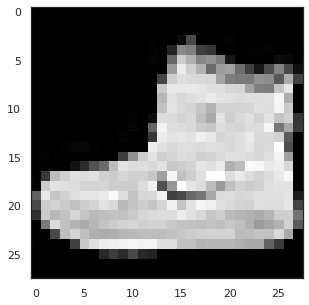

In [0]:
# 一双耐克鞋?
plt.figure(figsize = (10, 5))
pixels = train[0].reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

There is cost with moving data between host memory and device memory (GPU memory) and we will include that core when comparing speeds

In [93]:
%%time
record_data = (('fea%d'%i, data[:,i]) for i in range(data.shape[1]))
gdf = cudf.DataFrame(record_data)

label_data = [('fea%0', target)]

target_gdf = cudf.DataFrame(label_data)

CPU times: user 1.07 s, sys: 64.8 ms, total: 1.13 s
Wall time: 1.14 s


`gdf` is a GPU backed dataframe -- all the data is stored in the device memory of the GPU.  With the data converted, we can apply the `cumlUMAP` the same inputs as we do for the standard UMAP.

For datasets that provide a set of labels, we can pass those labels into the `fit()` and `fit_transform()` functions to have UMAP use them for better cluster separation. Supervised training can even be used with an incomplete set of labels by setting the unknown labels to -1". It is important that the labels array be the same size as the number of samples being used to train.

In [97]:
start = time.time()
g_embedding = cumlUMAP(n_neighbors=5, 
                       init="spectral").fit_transform(gdf)
                       
print("Took %f sec." % (time.time() - start))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  


Took 8.733225 sec.


In [0]:
#start = time.time()
#g_embedding_supervised = cumlUMAP(verbose = False, 
#                                  n_neighbors=5, 
#                                  init="spectral", 
#                                  target_metric = "categorical").fit_transform(gdf, target_gdf)
#                                  
#print("Took %f sec." % (time.time() - start))

## **Visualization**

OK, now let's plot the output of the embeddings so that we can see the seperation of the neighborhoods.  Let's start by creating the classes.

In [0]:
classes = ['T-shirt/top',
           'Trouser',
           'Pullover',
           'Dress',
           'Coat',
           'Sandal',
           'Shirt',
           'Sneaker',
           'Bag',
           'Ankle boot']

In [0]:
#Needs to be redone because of timeit function sometimes loses our g_embedding variable
g_embedding = cumlUMAP(n_neighbors=5, 
                       init="spectral").fit_transform(gdf)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  


Just as the original author of UMAP, Leland McInnes, states in the [UMAP docs](https://umap-learn.readthedocs.io/en/latest/supervised.html), we can plot the results and show the separation between the various classes defined above.

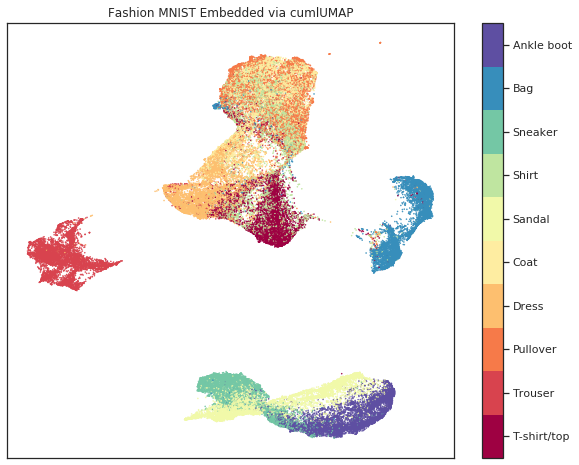

In [103]:
g_embedding_numpy = g_embedding.to_pandas().values      #it is necessary to convert to numpy array to do the visual mapping

fig, ax = plt.subplots(1, figsize=(10, 8))
plt.scatter(g_embedding_numpy[:,1], 
            g_embedding_numpy[:,0], 
            s=0.3, 
            c=target, 
            cmap='Spectral', 
            alpha=1.0)

plt.setp(ax, xticks=[], yticks=[])

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)

cbar.set_ticks(np.arange(10))

cbar.set_ticklabels(classes)

plt.title('Fashion MNIST Embedded via cumlUMAP');

## **Comparison of Implementations**
And side-by-side we can see the effects of supervised training.  Notice how providing the labels enables the resulting model to better separation of sneakers, ankle books, and sandals while also providing a much more distinct separation of shirts, t-shirts, pullovers, and coats. 

In [0]:
#g_embedding_numpy = g_embedding.to_pandas().values #it is necessary to convert to numpy array to do the visual mapping

#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

#ax[0].scatter(g_embedding_numpy[:,1], g_embedding_numpy[:,0], s=0.3, c=target, cmap='Spectral', alpha=1.0)

#im = ax[1].scatter(g_embedding_supervised_numpy[:,1], g_embedding_supervised_numpy[:,0], s=0.3, c=target, cmap='Spectral', alpha=1.0)

#ax[0].set_title('Unsupervised Fashion MNIST Embedded via cumlUMAP ');
#ax[1].set_title('Supervised Fashion MNIST Embedded via UMAP');

#fig.subplots_adjust(right=0.8)

#cax,kw = mpl.colorbar.make_axes([a for a in ax.flat])

#cbar = plt.colorbar(im, cax=cax, **kw)
#cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)

Additionally, we can also quanititaviely compare the perfomance of `cumlUMAP` (GPU UMAP) to the reference/original implementation (CPU UMAP) using the [trustworthiness score](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/manifold/t_sne.py#L395).  From the docstring:

> Trustworthiness expresses to what extent the local structure is retained.  The trustworthiness is within [0, 1].


Like `t-SNE`, UMAP tries to capture both global and local structure and thus, we can apply the `trustworthiness` of the `g_embedding` data against the original input.  With a higher score we are demonstrating that the algorithm does a better and better job of local structure retention.  As [Corey Nolet](https://github.com/cjnolet) notes:
> Algorithms like UMAP aim to preserve local neighborhood structure and so measuring this property (trustworthiness) measures the algorithm's performance.

Scoring ~97% shows the GPU implementation is comparable to the original CPU implementation and the training time was ~9.5X faster